In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

from scipy.signal import savgol_filter

from scipy.io import loadmat, savemat

sns.set_theme(font_scale=1.5)

epmc = loadmat("lookup_radiation.mat");

In [2]:
h = np.linspace(0, 999, 1000);
Earray = np.round(np.logspace(np.log10(0.250), np.log10(1000), 100), 2)

name_array = np.core.defchararray.add(np.repeat('E', 100), np.linspace(1, 100, 100).T.astype(int).astype(str));


def KrauseIonization(altitude):
    '''
    altitude in km
    returns ionization in keV
    '''
    r = (-0.03 * altitude + 39.78)/1e3;
    r[altitude > 240] = (-0.03 * 240 + 39.78)/1e3
    r[altitude < 45] = (-0.03 * 45 + 39.78)/1e3

    return r;

def readAndAverage(filename):
    data = pd.read_csv("../spectral_data/" + filename, names=['E']);

    lineNo   = 1000;

    nThreads = int(len(data)/lineNo);
        
    ionMean = np.zeros([1, lineNo]);
    ionVar     = np.zeros([1, lineNo]);
    for i in range(0, nThreads):
        ionMean += data.E[lineNo*i:lineNo*(i+1)]
        ionVar  += data.E[lineNo*i:lineNo*(i+1)]**2
        
    ionMean /= nThreads;
    
    return data, ionMean.flatten(), 1/nThreads * np.sqrt(ionVar.flatten() - ionMean.flatten()**2);

def readAndAverage2D(filename):
    
    Earray = np.round(np.logspace(np.log10(0.250), np.log10(1000), 100), 2)

    data = pd.read_csv("../spectral_data/" + filename, names=name_array);
    
    data.fillna(data.mean(), inplace=True)
        
    lineNo   = 1000;
    
    nThreads = int(len(data)/lineNo);

    results    = np.zeros([lineNo, 100]);
    resultsVar = np.zeros([lineNo, 100]);
    for i in range(0, nThreads):
        results += data.values[lineNo*i:lineNo*(i+1), :]
        resultsVar += (data.values[lineNo*i:lineNo*(i+1), :])**2
    
    results /= nThreads;
        
    return data, results, 1/nThreads * np.sqrt(resultsVar - results**2);
    

def plot_spectra(ionResults, EResults, ionVar, Evar):

    plt.figure(figsize=(14,8)); plt.subplot(1,2,1); 
    plt.grid(True, which='both')
    plt.plot(ionResults/KrauseIonization(h), h, label='$\mu$');
    plt.fill_betweenx(h, (ionResults-ionVar)/KrauseIonization(h), 
                         (ionResults+ionVar)/KrauseIonization(h), 
                      alpha=0.5, label='$\pm \sigma$')
    
    plt.xscale('log');
    plt.xlabel('Ionization Rate [cm$^{-3}$ s$^{-1}$]');
    plt.ylabel('Altitude [km]');
    plt.ylim([0, 240]);
    plt.legend()

    X,Y = np.meshgrid(Earray, h);

    plt.subplot(1,2,2); plt.grid(True, which='both')
    plt.contourf(X, Y, np.log10(EResults));
    plt.colorbar(label='log$_{10}$ Number of Occurances');

    plt.xscale('log');
    plt.xlabel('Energy [keV]');
    plt.ylabel('Altitude [km]');
    plt.ylim([0, 240]);

def plot_altitude_spectra(EResults, Evar):
    plt.figure(figsize=(10,6)); plt.grid(True, which='both');

    startingAlt = 10;
    stepSize    = 5;

    for j in range(0, 4):

        h1 = startingAlt + j*stepSize;
        h2 = startingAlt + stepSize + j*stepSize;

        ave    = np.zeros([1, len(Earray)])
        aveVar = np.zeros([1, len(Earray)])
        for i in range(h1, h2):
            ave += EResults[i, :]
            aveVar += np.sqrt(Evar[i,:])

        plt.errorbar(Earray, savgol_filter(ave[0,:], 7, 2), aveVar[0,:], label='%.0f - %.0f km' % (h1,h2));

    plt.xscale('log');
    plt.yscale('log');
    plt.legend();
    plt.xlabel('Energy [keV]');
    plt.ylabel('Relative Intensity');
    plt.title('Average Spectra with Altitude');

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10


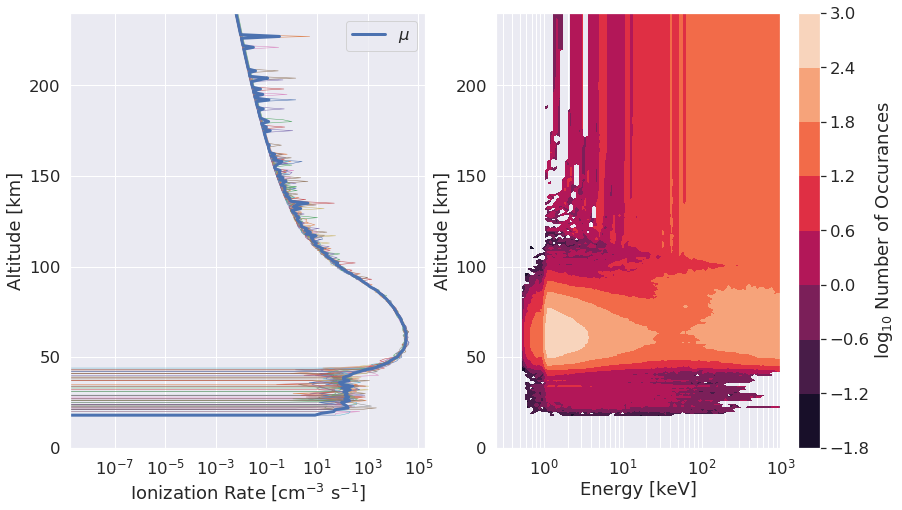

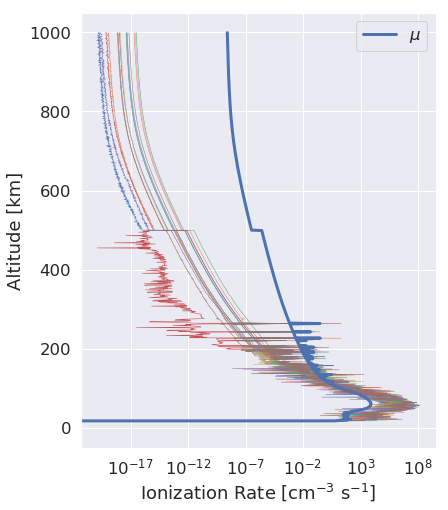

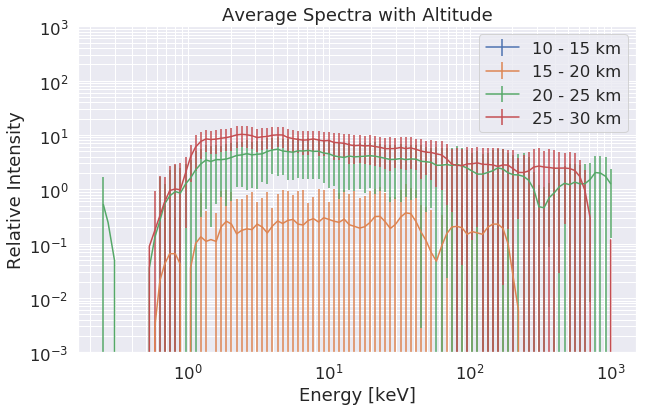

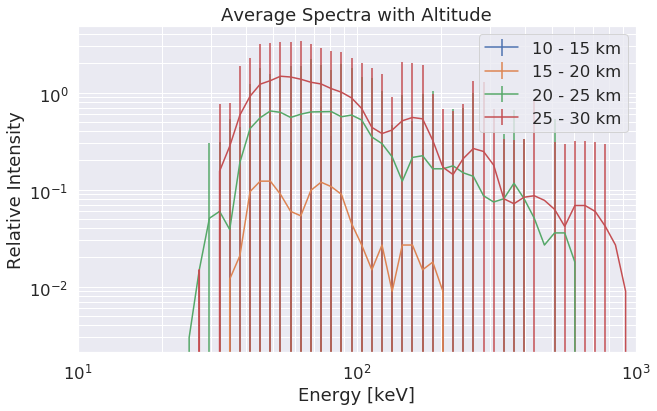

In [3]:
fn1 = "electron_dep_test.csv";
fn2 = "electron_ene_test.csv";
fn3 = "photon_dep_test.csv";
fn4 = "photon_ene_test.csv";

d1, ionResults, ionVar       = readAndAverage(fn1);
d2, EResults, Evar           = readAndAverage2D(fn2);
d3, ph_ionResults, ph_ionVar = readAndAverage(fn3);
d4, ph_EResults, ph_Evar     = readAndAverage2D(fn4);

plt.figure(figsize=(14,8)); plt.subplot(1,2,1); 
plt.grid(True, which='both')
for i in range(0, len(d1)//1000):
    plt.plot(d1[1000*i:1000*(i+1)], h, lineWidth=0.5)

plt.plot(ionResults, h, 'b', label='$\mu$', lineWidth=3);

plt.xscale('log');
plt.xlabel('Ionization Rate [cm$^{-3}$ s$^{-1}$]');
plt.ylabel('Altitude [km]');
plt.ylim([0, 240]);
plt.legend();


X,Y = np.meshgrid(Earray, h);

plt.subplot(1,2,2); plt.grid(True, which='both')
plt.contourf(X, Y, np.log10(EResults));
plt.colorbar(label='log$_{10}$ Number of Occurances');

plt.xscale('log');
plt.xlabel('Energy [keV]');
plt.ylabel('Altitude [km]');
plt.ylim([0, 240]);
#plt.xlim([]);


plt.figure(figsize=(14,8)); plt.subplot(1,2,1); 
plt.grid(True, which='both')
for i in range(0, len(d1)//1000):
    plt.plot((d1[1000*i:1000*(i+1)].values.flatten() - ionResults)**2, h, 
             lineWidth=0.5)

plt.plot(ionVar, h, 'b', label='$\mu$', lineWidth=3);

plt.xscale('log');
plt.xlabel('Ionization Rate [cm$^{-3}$ s$^{-1}$]');
plt.ylabel('Altitude [km]');
#plt.ylim([0, 240]);
plt.legend();



plot_altitude_spectra(EResults, Evar);
plt.ylim([1e-3, 1e3]);
plot_altitude_spectra(ph_EResults, ph_Evar)
plt.xlim([1e1, 1e3]);

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log10


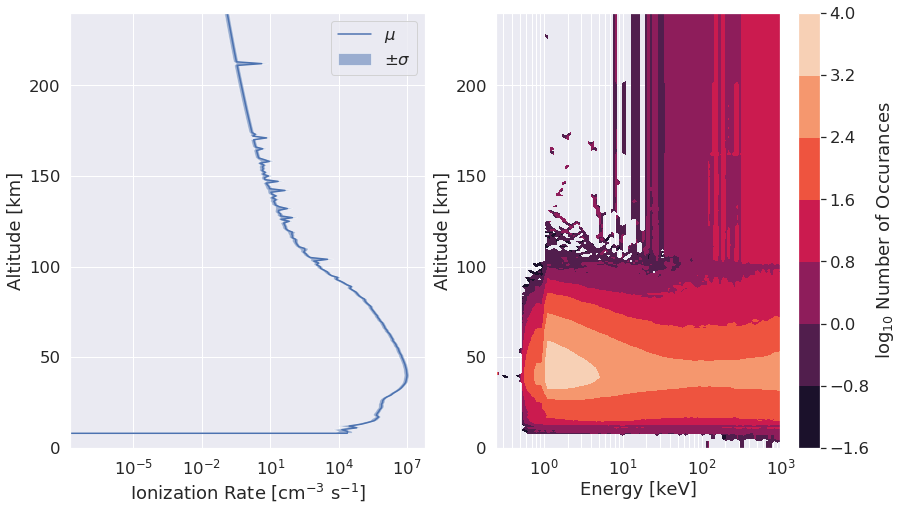

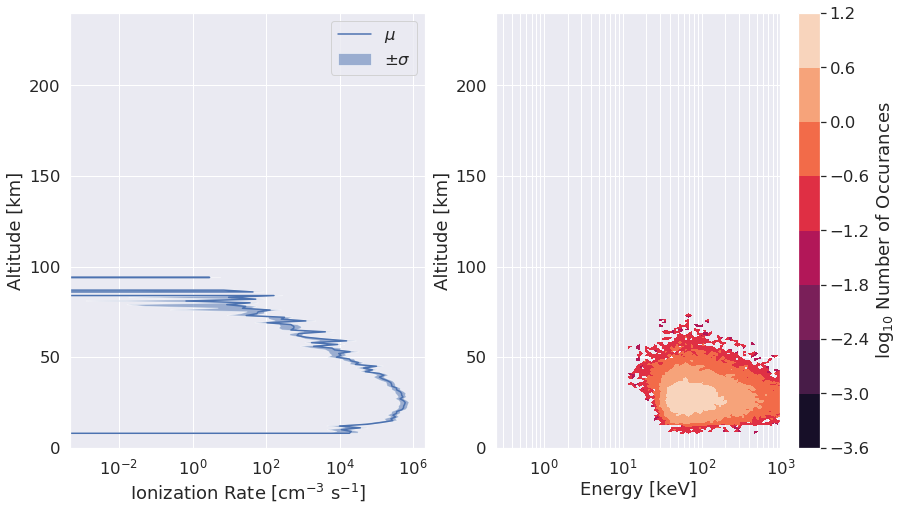

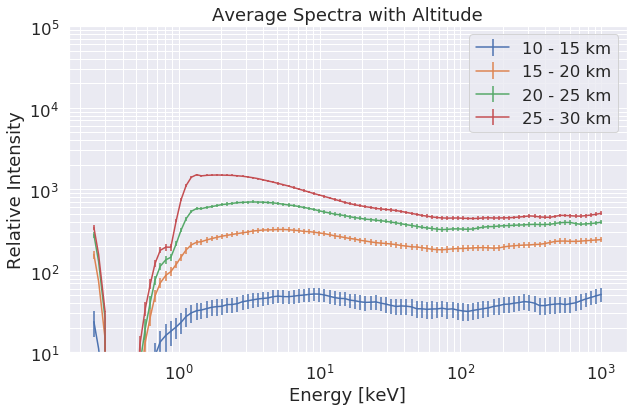

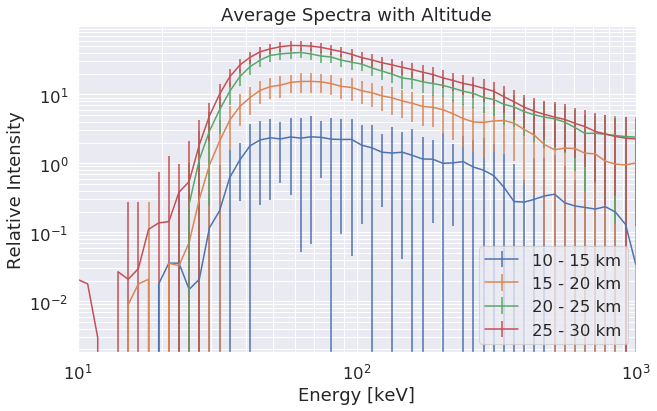

In [4]:
fn1 = "electron_dep_test10MeV.csv";
fn2 = "electron_ene_test10MeV.csv";
fn3 = "photon_dep_test10MeV.csv";
fn4 = "photon_ene_test10MeV.csv";

_, ionResults, ionVar       = readAndAverage(fn1);
_, EResults, Evar           = readAndAverage2D(fn2);
_, ph_ionResults, ph_ionVar = readAndAverage(fn3);
_, ph_EResults, ph_Evar     = readAndAverage2D(fn4);

saveName = "G4_sinePAD_mono10MeV.mat"
savemat(saveName,                   {"electronIonization": ionResults,
                                     "electronIonization_stddev": ionVar,
                                     "electronEnergyDep": EResults, 
                                     "electronEnergyDep_stddev": Evar,
                                     "photonIonization": ph_ionResults,
                                     "photonIonization_stddev": ph_ionVar,
                                     "photonEnergyDep": ph_EResults,
                                     "photonEnergyDep_stddev": ph_Evar})


plot_spectra(ionResults, EResults, ionVar, Evar);
plot_spectra(ph_ionResults, ph_EResults, ph_ionVar, ph_Evar)

plot_altitude_spectra(EResults, Evar);
plt.ylim([1e1, 1e5]);
plot_altitude_spectra(ph_EResults, ph_Evar)
plt.xlim([1e1, 1e3]);

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log10


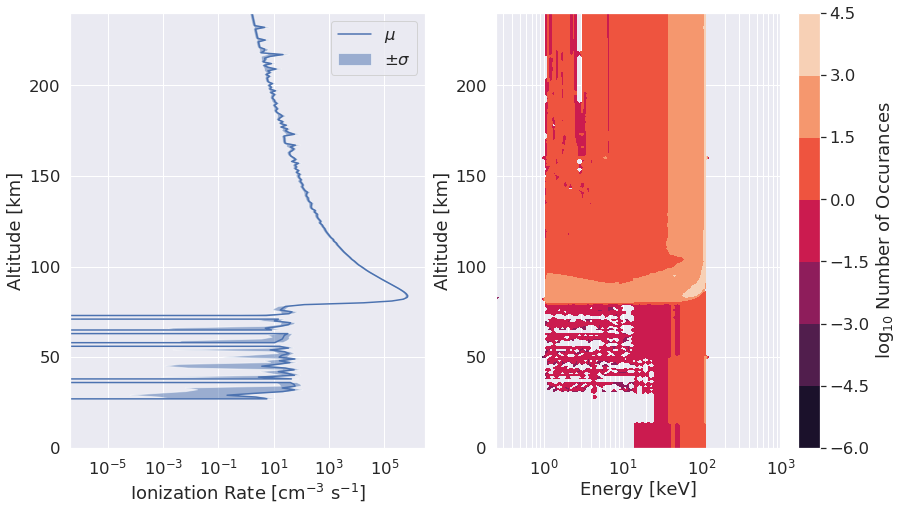

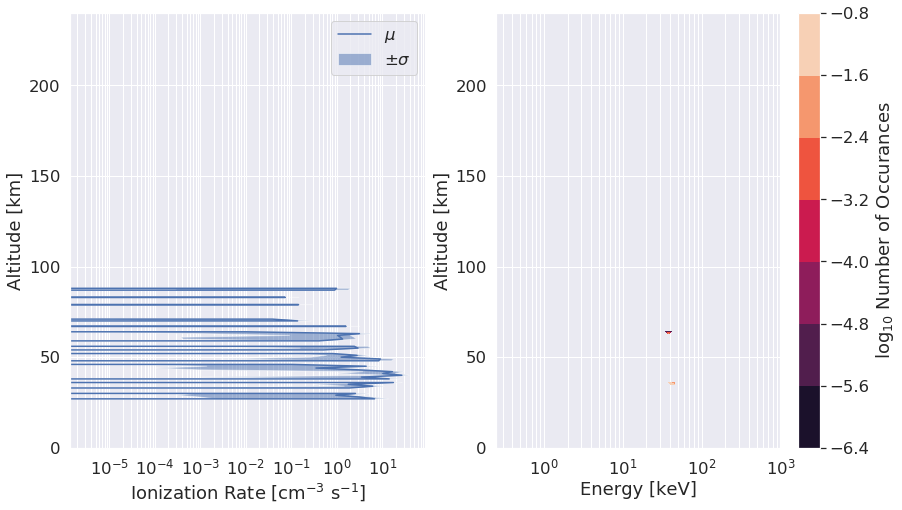

In [4]:
post = '100'

fn1 = "electron_dep_spectra" + post + "keV_iso_1e5.csv";
fn2 = "electron_ene_spectra" + post + "keV_iso_1e5.csv";
fn3 = "photon_dep_spectra" + post   + "keV_iso_1e5.csv";
fn4 = "photon_ene_spectra" + post   + "keV_iso_1e5.csv";

_, ionResults, ionVar       = readAndAverage(fn1);
_, EResults, Evar           = readAndAverage2D(fn2);
_, ph_ionResults, ph_ionVar = readAndAverage(fn3);
_, ph_EResults, ph_Evar     = readAndAverage2D(fn4);


plot_spectra(ionResults, EResults, ionVar, Evar);
plot_spectra(ph_ionResults, ph_EResults, ph_ionVar, ph_Evar)

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log10


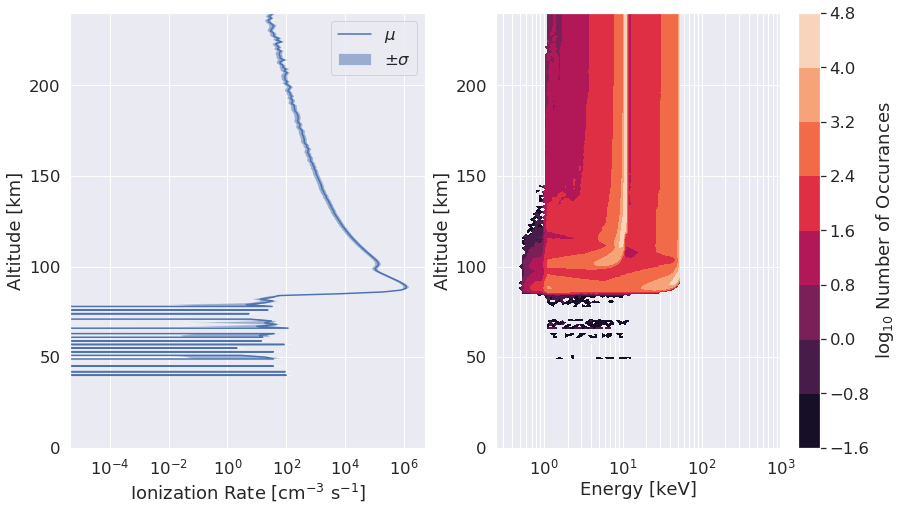

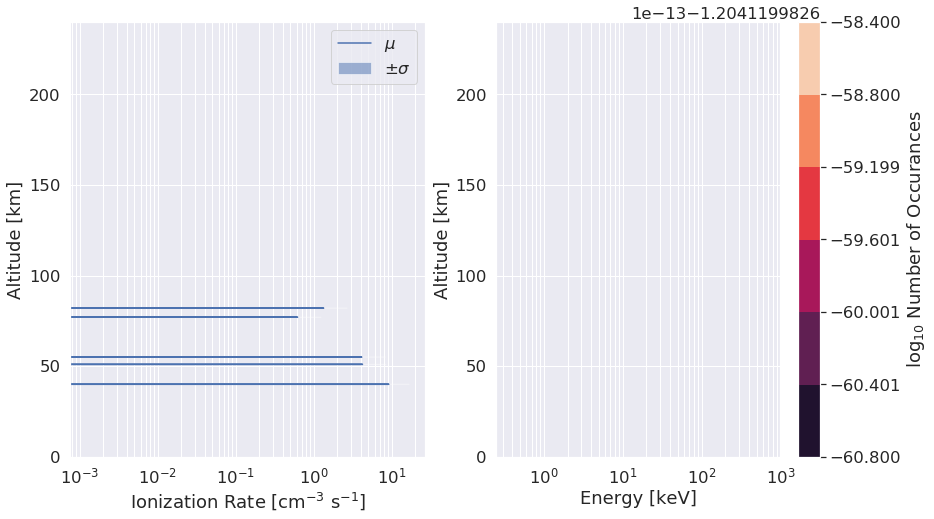

In [6]:
fn1 = "electron_dep_spectra50keV.csv";
fn2 = "electron_ene_spectra50keV.csv";
fn3 = "photon_dep_spectra50keV.csv";
fn4 = "photon_ene_spectra50keV.csv";

_, ionResults, ionVar       = readAndAverage(fn1);
_, EResults, Evar           = readAndAverage2D(fn2);
_, ph_ionResults, ph_ionVar = readAndAverage(fn3);
_, ph_EResults, ph_Evar     = readAndAverage2D(fn4);


saveName = "G4_sinePAD_mono50keV.mat"
savemat(saveName,                   {"electronIonization": ionResults,
                                     "electronIonization_stddev": ionVar,
                                     "electronEnergyDep": EResults, 
                                     "electronEnergyDep_stddev": Evar,
                                     "photonIonization": ph_ionResults,
                                     "photonIonization_stddev": ph_ionVar,
                                     "photonEnergyDep": ph_EResults,
                                     "photonEnergyDep_stddev": ph_Evar})

plot_spectra(ionResults, EResults, ionVar, Evar);
plot_spectra(ph_ionResults, ph_EResults, ph_ionVar, ph_Evar)

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log10


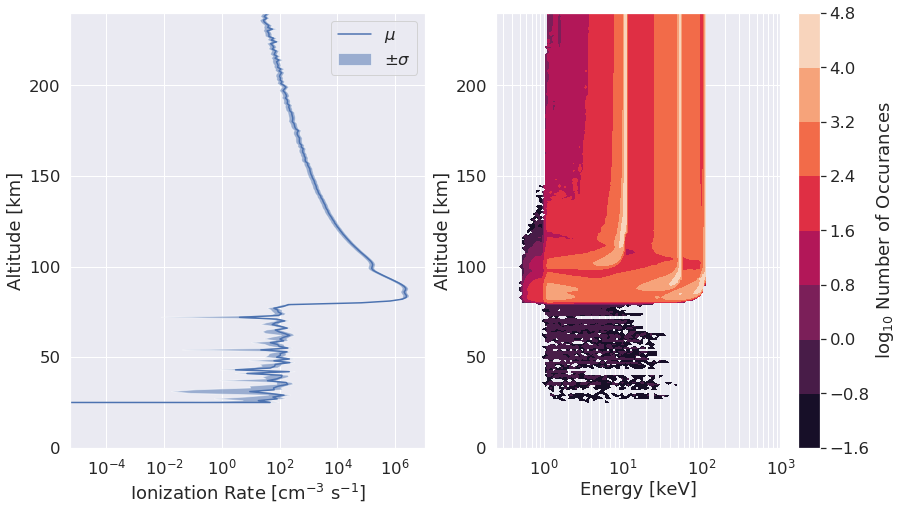

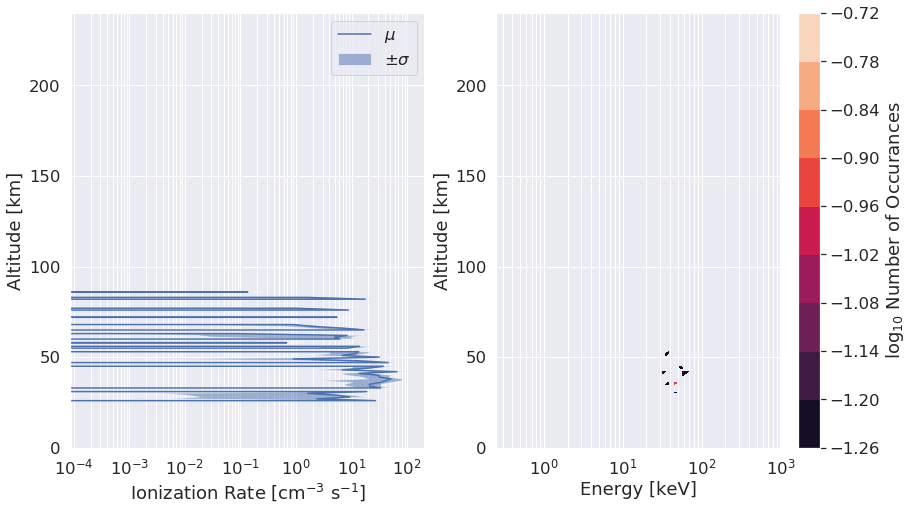

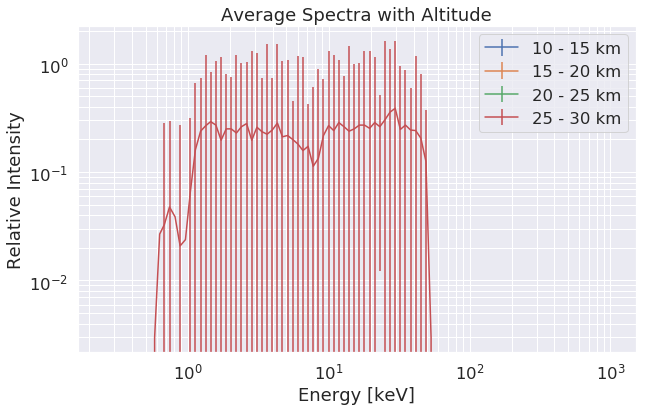

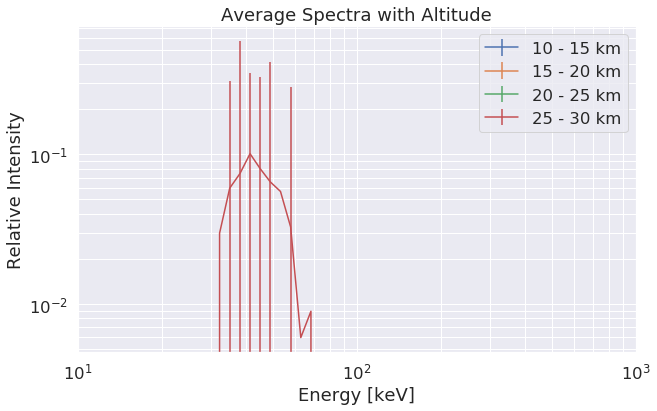

In [7]:
fn1 = "electron_dep_spectra100keV.csv";
fn2 = "electron_ene_spectra100keV.csv";
fn3 = "photon_dep_spectra100keV.csv";
fn4 = "photon_ene_spectra100keV.csv";

_, ionResults, ionVar       = readAndAverage(fn1);
_, EResults, Evar           = readAndAverage2D(fn2);
_, ph_ionResults, ph_ionVar = readAndAverage(fn3);
_, ph_EResults, ph_Evar     = readAndAverage2D(fn4);

saveName = "G4_sinePAD_mono100keV.mat"
savemat(saveName,                   {"electronIonization": ionResults,
                                     "electronIonization_stddev": ionVar,
                                     "electronEnergyDep": EResults, 
                                     "electronEnergyDep_stddev": Evar,
                                     "photonIonization": ph_ionResults,
                                     "photonIonization_stddev": ph_ionVar,
                                     "photonEnergyDep": ph_EResults,
                                     "photonEnergyDep_stddev": ph_Evar})

plot_spectra(ionResults, EResults, ionVar, Evar);
plot_spectra(ph_ionResults, ph_EResults, ph_ionVar, ph_Evar)

plot_altitude_spectra(EResults, Evar);
#plt.ylim([1e1, 1e5]);
plot_altitude_spectra(ph_EResults, ph_Evar)
plt.xlim([1e1, 1e3]);

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log10


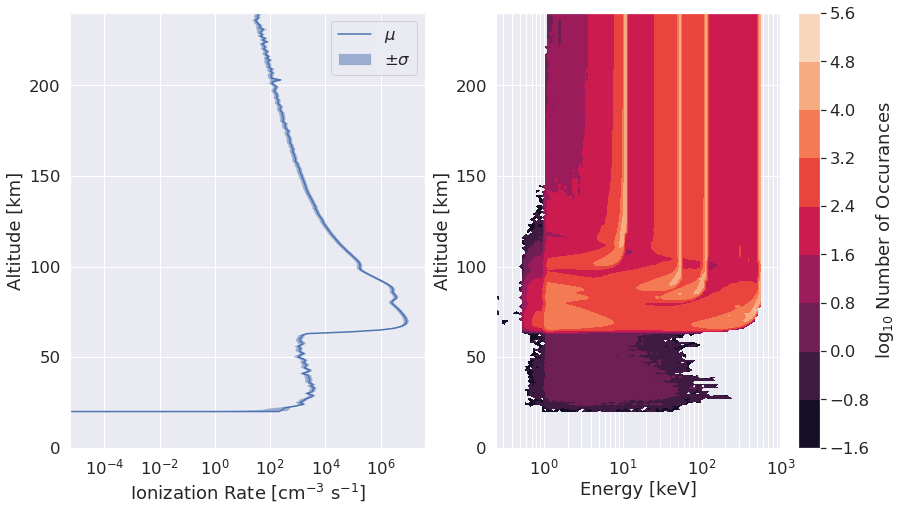

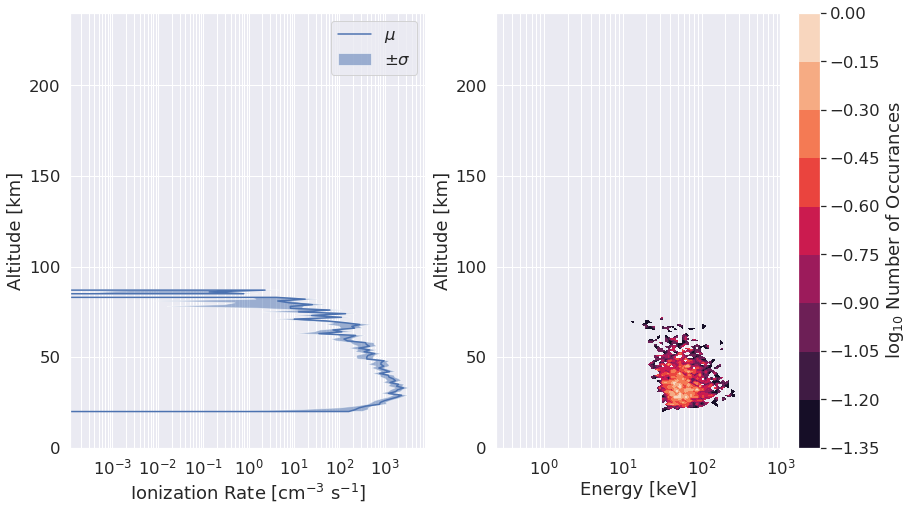

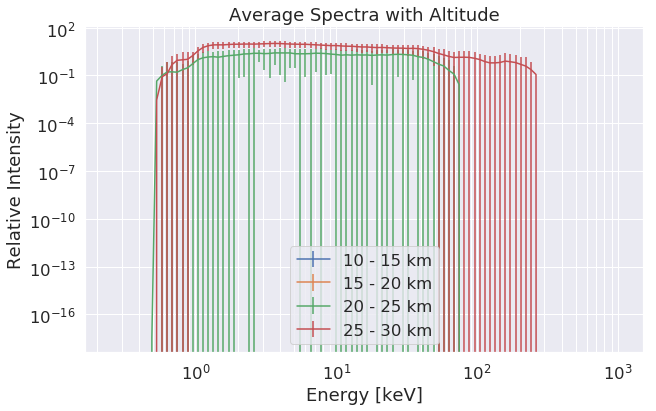

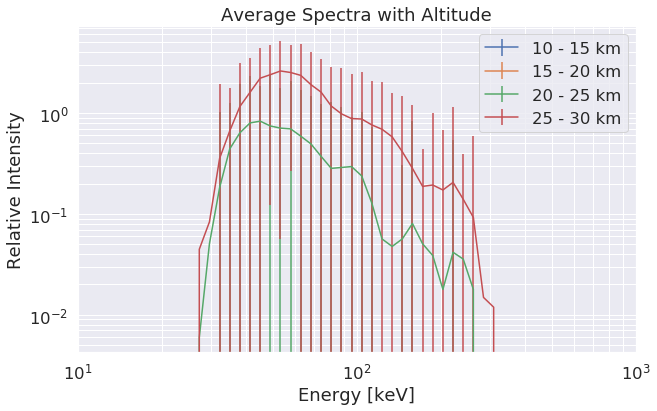

In [8]:
post = '500';

fn1 = "electron_dep_spectra" + post + "keV.csv";
fn2 = "electron_ene_spectra" + post + "keV.csv";
fn3 = "photon_dep_spectra" + post + "keV.csv";
fn4 = "photon_ene_spectra" + post + "keV.csv";

_, ionResults, ionVar       = readAndAverage(fn1);
_, EResults, Evar           = readAndAverage2D(fn2);
_, ph_ionResults, ph_ionVar = readAndAverage(fn3);
_, ph_EResults, ph_Evar     = readAndAverage2D(fn4);

saveName = "G4_sinePAD_mono500keV.mat"
savemat(saveName,                   {"electronIonization": ionResults,
                                     "electronIonization_stddev": ionVar,
                                     "electronEnergyDep": EResults, 
                                     "electronEnergyDep_stddev": Evar,
                                     "photonIonization": ph_ionResults,
                                     "photonIonization_stddev": ph_ionVar,
                                     "photonEnergyDep": ph_EResults,
                                     "photonEnergyDep_stddev": ph_Evar})

plot_spectra(ionResults, EResults, ionVar, Evar);
plot_spectra(ph_ionResults, ph_EResults, ph_ionVar, ph_Evar)

plot_altitude_spectra(EResults, Evar);
#plt.ylim([1e1, 1e5]);
plot_altitude_spectra(ph_EResults, ph_Evar)
plt.xlim([1e1, 1e3]);

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log10


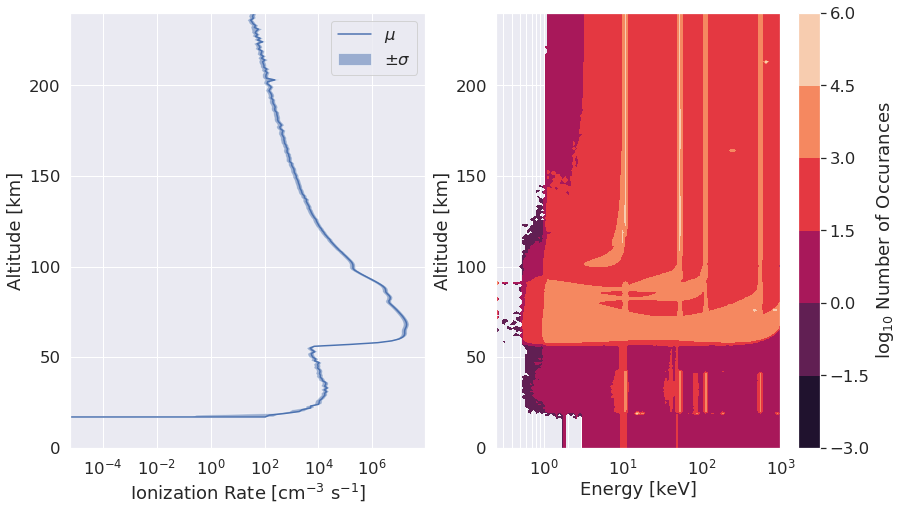

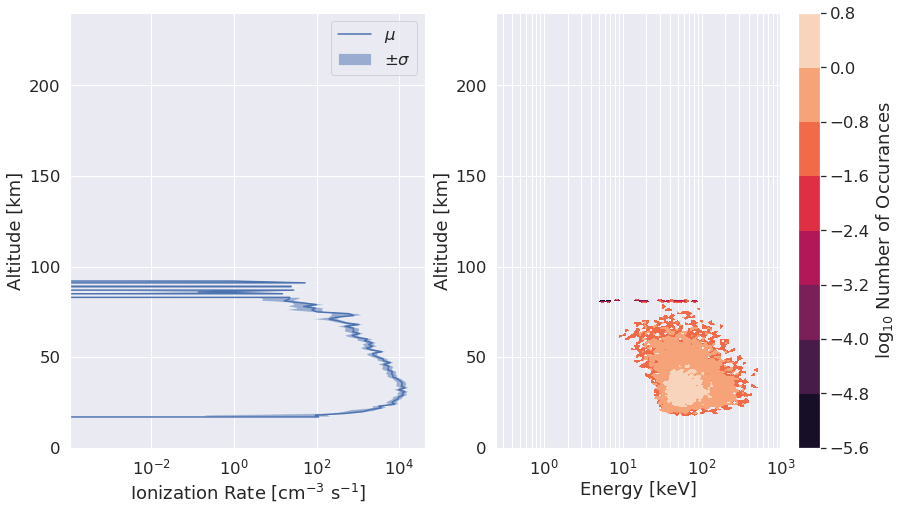

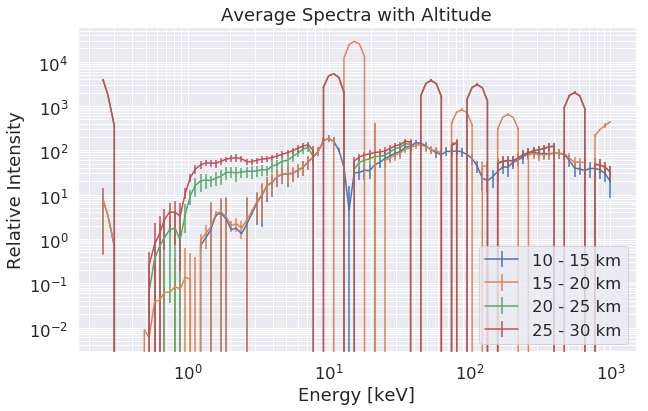

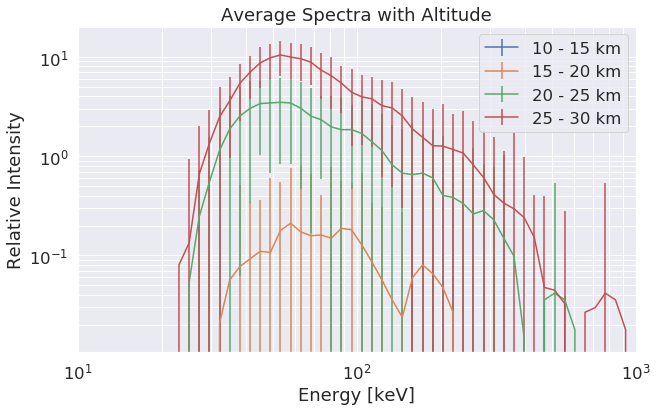

In [9]:
post = '1000';

fn1 = "electron_dep_spectra" + post + "keV.csv";
fn2 = "electron_ene_spectra" + post + "keV.csv";
fn3 = "photon_dep_spectra" + post + "keV.csv";
fn4 = "photon_ene_spectra" + post + "keV.csv";

_, ionResults, ionVar       = readAndAverage(fn1);
_, EResults, Evar           = readAndAverage2D(fn2);
_, ph_ionResults, ph_ionVar = readAndAverage(fn3);
_, ph_EResults, ph_Evar     = readAndAverage2D(fn4);


saveName = "G4_sinePAD_mono1000keV.mat"
savemat(saveName,                   {"electronIonization": ionResults,
                                     "electronIonization_stddev": ionVar,
                                     "electronEnergyDep": EResults, 
                                     "electronEnergyDep_stddev": Evar,
                                     "photonIonization": ph_ionResults,
                                     "photonIonization_stddev": ph_ionVar,
                                     "photonEnergyDep": ph_EResults,
                                     "photonEnergyDep_stddev": ph_Evar})

plot_spectra(ionResults, EResults, ionVar, Evar);
plot_spectra(ph_ionResults, ph_EResults, ph_ionVar, ph_Evar)

plot_altitude_spectra(EResults, Evar);
#plt.ylim([1e1, 1e5]);
plot_altitude_spectra(ph_EResults, ph_Evar)
plt.xlim([1e1, 1e3]);

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log10


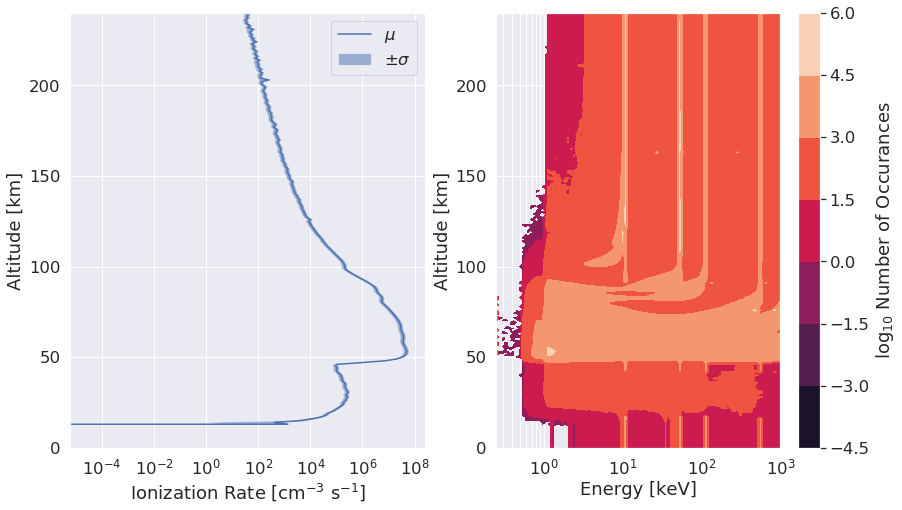

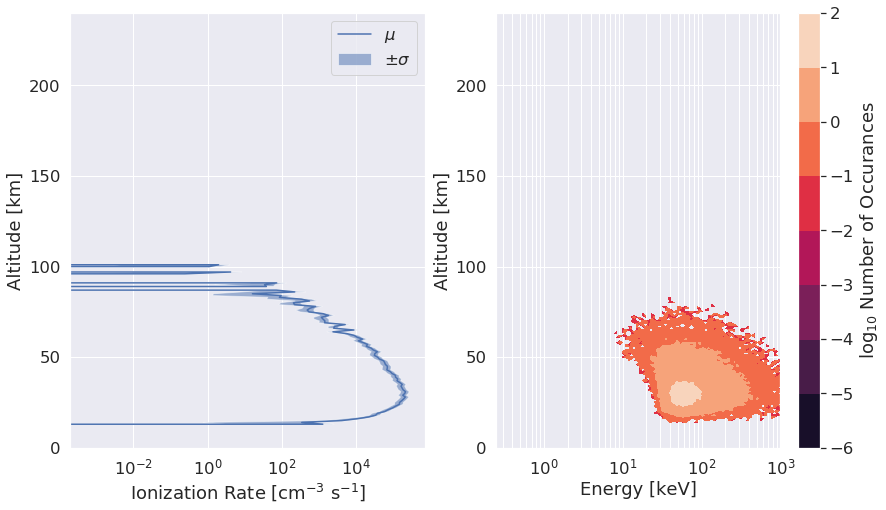

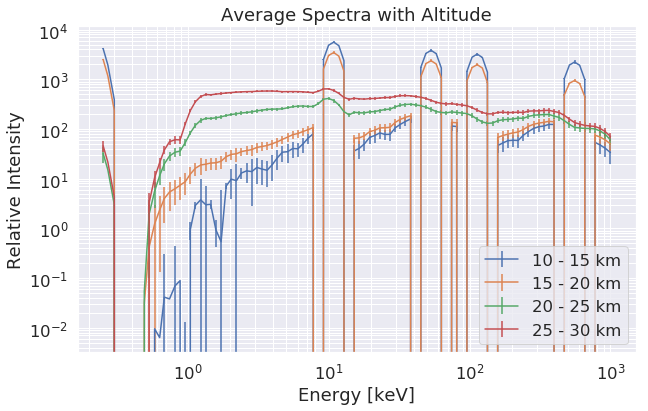

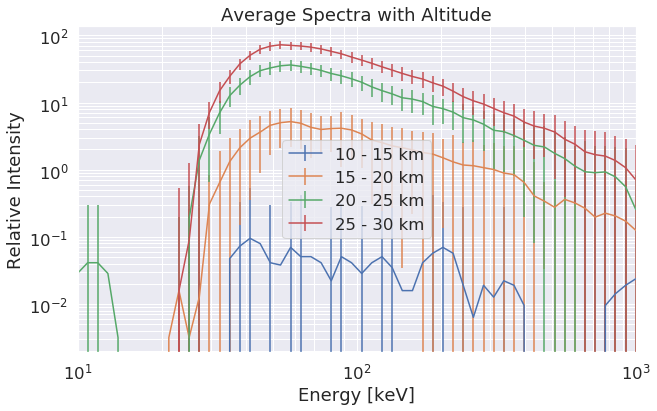

In [10]:
post = '3000';

fn1 = "electron_dep_spectra" + post + "keV.csv";
fn2 = "electron_ene_spectra" + post + "keV.csv";
fn3 = "photon_dep_spectra" + post + "keV.csv";
fn4 = "photon_ene_spectra" + post + "keV.csv";

_, ionResults, ionVar       = readAndAverage(fn1);
_, EResults, Evar           = readAndAverage2D(fn2);
_, ph_ionResults, ph_ionVar = readAndAverage(fn3);
_, ph_EResults, ph_Evar     = readAndAverage2D(fn4);



saveName = "G4_sinePAD_mono3000keV.mat"
savemat(saveName,                   {"electronIonization": ionResults,
                                     "electronIonization_stddev": ionVar,
                                     "electronEnergyDep": EResults, 
                                     "electronEnergyDep_stddev": Evar,
                                     "photonIonization": ph_ionResults,
                                     "photonIonization_stddev": ph_ionVar,
                                     "photonEnergyDep": ph_EResults,
                                     "photonEnergyDep_stddev": ph_Evar})

plot_spectra(ionResults, EResults, ionVar, Evar);
plot_spectra(ph_ionResults, ph_EResults, ph_ionVar, ph_Evar)

plot_altitude_spectra(EResults, Evar);
#plt.ylim([1e1, 1e5]);
plot_altitude_spectra(ph_EResults, ph_Evar)
plt.xlim([1e1, 1e3]);

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log10


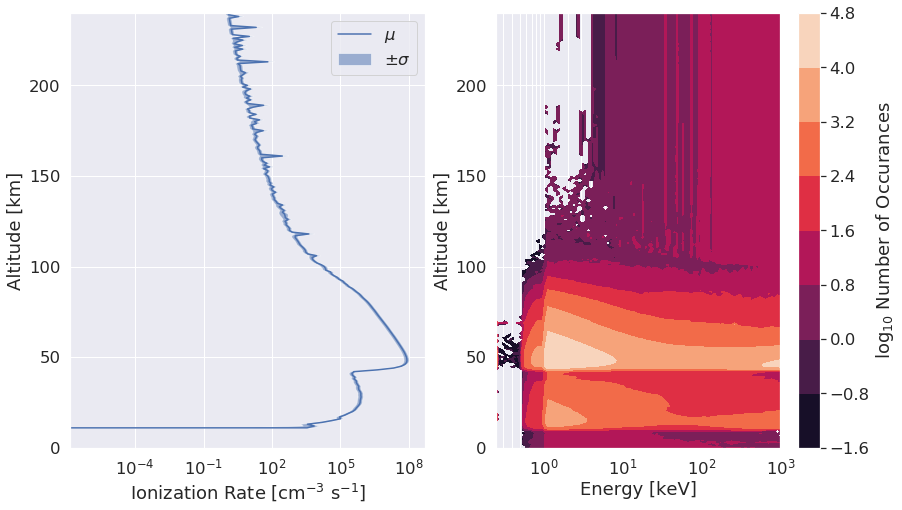

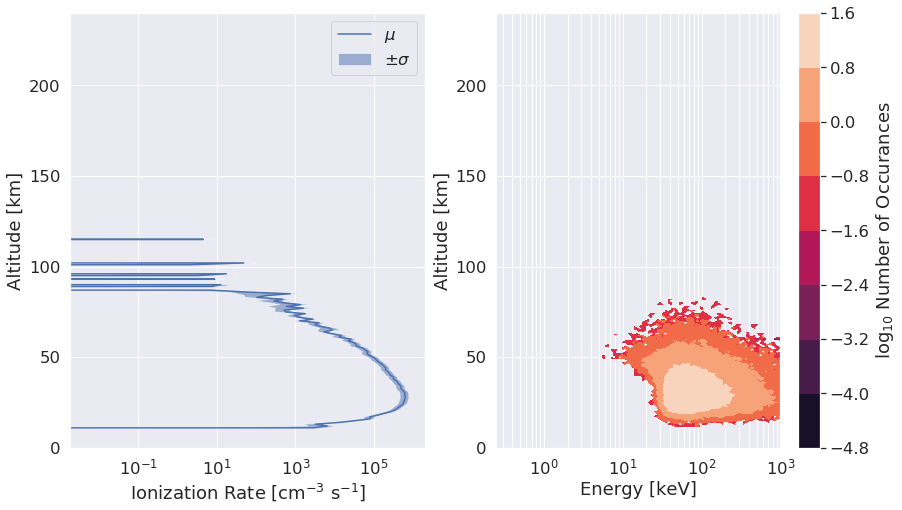

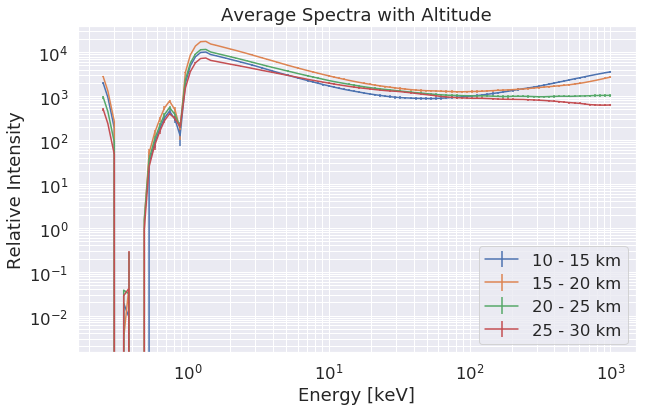

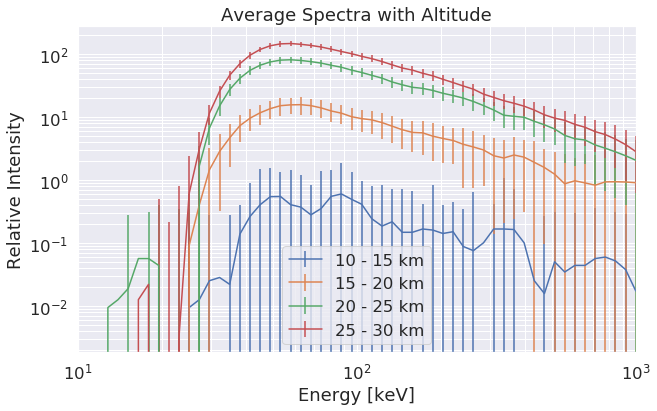

In [11]:
post = '5000';

fn1 = "electron_dep_spectra" + post + "keV.csv";
fn2 = "electron_ene_spectra" + post + "keV.csv";
fn3 = "photon_dep_spectra" + post + "keV.csv";
fn4 = "photon_ene_spectra" + post + "keV.csv";

_, ionResults, ionVar       = readAndAverage(fn1);
_, EResults, Evar           = readAndAverage2D(fn2);
_, ph_ionResults, ph_ionVar = readAndAverage(fn3);
_, ph_EResults, ph_Evar     = readAndAverage2D(fn4);


saveName = "G4_sinePAD_mono5000keV.mat"
savemat(saveName,                   {"electronIonization": ionResults,
                                     "electronIonization_stddev": ionVar,
                                     "electronEnergyDep": EResults, 
                                     "electronEnergyDep_stddev": Evar,
                                     "photonIonization": ph_ionResults,
                                     "photonIonization_stddev": ph_ionVar,
                                     "photonEnergyDep": ph_EResults,
                                     "photonEnergyDep_stddev": ph_Evar})


plot_spectra(ionResults, EResults, ionVar, Evar);
plot_spectra(ph_ionResults, ph_EResults, ph_ionVar, ph_Evar)

plot_altitude_spectra(EResults, Evar);
#plt.ylim([1e1, 1e5]);
plot_altitude_spectra(ph_EResults, ph_Evar)
plt.xlim([1e1, 1e3]);